In [5]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from torchvision import transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pickle
from torchsummary import summary

import keras, keras.layers

In [43]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

In [80]:
class Emotions_dataset(Dataset):
    def __init__(self, files, mode, y):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = y
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [56]:
TRAIN_DIR = Path('C:/image_3_emo_data_crema')
TEST_DIR = Path('C:/image_3_emo_data_crema_test')

In [2]:
torch.cuda.is_available()
DEVICE = torch.device("cuda")

In [3]:
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        logits = nn.functional.softmax(logits)
        return logits

In [12]:
model = SimpleCnn(4)

In [15]:
summary(model.to(DEVICE), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,168
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 32, 52, 52]           4,640
              ReLU-8           [-1, 32, 52, 52]               0
         MaxPool2d-9           [-1, 32, 26, 26]               0
           Conv2d-10           [-1, 64, 24, 24]          18,496
             ReLU-11           [-1, 64, 24, 24]               0
        MaxPool2d-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 96, 10, 10]          55,392
             ReLU-14           [-1, 96,

C:\Users\ivvag\AppData\Local\Temp\ipykernel_12316\3042360963.py:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = nn.functional.softmax(logits)


In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

conv1.0.weight tensor([[[[-0.1494, -0.0113, -0.1143],
          [ 0.0037, -0.1042, -0.1761],
          [ 0.0766,  0.1429,  0.0939]],

         [[-0.1862,  0.0863,  0.1193],
          [-0.1876,  0.1418, -0.0880],
          [-0.1236, -0.1684,  0.1275]],

         [[ 0.0385, -0.0166, -0.0580],
          [ 0.0145,  0.0877,  0.0795],
          [-0.1108, -0.1556, -0.1547]]],


        [[[ 0.1628,  0.1174, -0.0784],
          [-0.0629, -0.0338, -0.0628],
          [ 0.0885,  0.0429, -0.1604]],

         [[ 0.0892,  0.0446, -0.1759],
          [-0.0050, -0.1441,  0.0920],
          [ 0.1057,  0.1736, -0.1045]],

         [[ 0.1450,  0.1876, -0.0724],
          [-0.0697, -0.0801,  0.0901],
          [ 0.1168,  0.1284,  0.0122]]],


        [[[ 0.0050, -0.0924,  0.0364],
          [-0.0540, -0.0029,  0.0134],
          [ 0.0055, -0.0434,  0.0497]],

         [[ 0.0813,  0.1064, -0.0274],
          [ 0.1270, -0.0865,  0.1432],
          [ 0.0103,  0.0745, -0.1386]],

         [[-0.1735,  0.0199, 

In [61]:
def fit_epoch(model, train_loader, criterion, optim):
  model.train()
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0

  for inputs, labels in train_loader:
    labels = labels.type(torch.LongTensor)
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    optim.zero_grad()

    outp = model(inputs)
    #outp = torch.argmax(outp, 1)
    #outp = torch.tensor(outp, dtype = torch.float32)
    loss = criterion(outp, labels)
    loss.backward()
    optim.step()

    preds = torch.argmax(outp, 1)
    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_corrects.cpu().numpy() / processed_data

  return train_loss, train_acc

In [84]:
def eval_epoch(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_corrects = 0
  processed_data = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)

    with torch.set_grad_enabled(False):
      outp = model(inputs)
      loss = criterion(outp, labels)
      preds = torch.argmax(outp, 1)

    running_loss += loss.item() * inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  val_loss = running_loss / processed_data
  val_acc = running_corrects.double() / processed_data

  return val_loss, val_acc

In [63]:
def train(model, train_files, val_files, epochs, batch_size, lr):
  train_loader = DataLoader(train_files, batch_size = batch_size, shuffle = True)
  val_loader = DataLoader(val_files, batch_size = batch_size, shuffle = False)

  history = []
  log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
  val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

  with tqdm(desc = 'epoch', total = epochs) as pbar_outer:
    optim = torch.optim.Adam(model.parameters(), lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
      train_loss, train_acc = fit_epoch(model, train_loader, criterion, optim)
      print('loss: ', train_loss)

      val_loss, val_acc = eval_epoch(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))

      pbar_outer.update(1)
      tqdm.write(log_template.format(ep = epoch + 1, t_loss = train_loss, v_loss = val_loss, t_acc = train_acc, v_acc = val_acc))

  return history

In [64]:
y = pd.read_csv('C:/обучение/Crema_df_3emo.csv')

In [65]:
y

,Unnamed: 0,Emotions,Path
0,0,happy,cremad/AudioWAV/1001_DFA_HAP_XX.wav
1,1,neutral,cremad/AudioWAV/1001_DFA_NEU_XX.wav
2,2,sad,cremad/AudioWAV/1001_DFA_SAD_XX.wav
3,3,happy,cremad/AudioWAV/1001_IEO_HAP_HI.wav
4,4,happy,cremad/AudioWAV/1001_IEO_HAP_LO.wav
...,...,...,...
3624,3624,neutral,cremad/AudioWAV/1091_TSI_NEU_XX.wav
3625,3625,sad,cremad/AudioWAV/1091_TSI_SAD_XX.wav
3626,3626,happy,cremad/AudioWAV/1091_WSI_HAP_XX.wav
3627,3627,neutral,cremad/AudioWAV/1091_WSI_NEU_XX.wav


In [66]:
labels = pd.get_dummies(y['Emotions'])
labels

,happy,neutral,sad
0,True,False,False
1,False,True,False
2,False,False,True
3,True,False,False
4,True,False,False
...,...,...,...
3624,False,True,False
3625,False,False,True
3626,True,False,False
3627,False,True,False


In [81]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.png')))
test_files = sorted(list(TEST_DIR.rglob('*.png')))
y_np = np.array(y['Emotions'].loc[:3028])
y_t = np.array(y['Emotions'].loc[3028:])

train_files, val_files, y_train, y_val = train_test_split(train_val_files, y_np, test_size=0.2)

In [70]:
val_dataset = Emotions_dataset(val_files, mode = 'val', y = y_val)
train_dataset = Emotions_dataset(train_files, mode = 'train', y = y_train)

In [82]:
test_dataset = Emotions_dataset(test_files, mode = 'test', y = y_t)

In [71]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [72]:
torch.cuda.empty_cache()

In [73]:
n_classes = len(np.unique(y_val))
custom = SimpleCnn(n_classes).to(DEVICE)

history = train(custom, train_dataset, val_dataset, epochs = 15, batch_size = 128, lr = 1e-4)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss:  1.0984845050248144


epoch:   7%|▋         | 1/15 [00:52<12:12, 52.29s/it]


Epoch 001 train_loss: 1.0985   val_loss 1.0981 train_acc 0.3463 val_acc 0.3284
loss:  1.0968215040465894


epoch:  13%|█▎        | 2/15 [01:25<08:52, 40.98s/it]


Epoch 002 train_loss: 1.0968   val_loss 1.0975 train_acc 0.3558 val_acc 0.3284
loss:  1.0960742784245074


epoch:  20%|██        | 3/15 [01:58<07:29, 37.46s/it]


Epoch 003 train_loss: 1.0961   val_loss 1.0979 train_acc 0.3558 val_acc 0.3284
loss:  1.0957278100803673


epoch:  27%|██▋       | 4/15 [02:31<06:32, 35.69s/it]


Epoch 004 train_loss: 1.0957   val_loss 1.0976 train_acc 0.3558 val_acc 0.3284
loss:  1.0957916004816166


epoch:  33%|███▎      | 5/15 [03:04<05:47, 34.79s/it]


Epoch 005 train_loss: 1.0958   val_loss 1.0977 train_acc 0.3558 val_acc 0.3284
loss:  1.095652150802754


epoch:  40%|████      | 6/15 [03:37<05:07, 34.21s/it]


Epoch 006 train_loss: 1.0957   val_loss 1.0976 train_acc 0.3558 val_acc 0.3284
loss:  1.0956108239973275


epoch:  47%|████▋     | 7/15 [04:11<04:31, 33.93s/it]


Epoch 007 train_loss: 1.0956   val_loss 1.0975 train_acc 0.3578 val_acc 0.3284
loss:  1.095586449116948


epoch:  53%|█████▎    | 8/15 [04:44<03:56, 33.79s/it]


Epoch 008 train_loss: 1.0956   val_loss 1.0981 train_acc 0.3558 val_acc 0.3284
loss:  1.0957774525086248


epoch:  60%|██████    | 9/15 [05:18<03:22, 33.73s/it]


Epoch 009 train_loss: 1.0958   val_loss 1.0973 train_acc 0.3586 val_acc 0.3284
loss:  1.0954627135151238


epoch:  67%|██████▋   | 10/15 [05:51<02:47, 33.50s/it]


Epoch 010 train_loss: 1.0955   val_loss 1.0980 train_acc 0.3562 val_acc 0.3284
loss:  1.0954773177600723


epoch:  73%|███████▎  | 11/15 [06:24<02:13, 33.31s/it]


Epoch 011 train_loss: 1.0955   val_loss 1.0976 train_acc 0.3710 val_acc 0.3284
loss:  1.0953756918161308


epoch:  80%|████████  | 12/15 [06:56<01:39, 33.09s/it]


Epoch 012 train_loss: 1.0954   val_loss 1.0977 train_acc 0.3558 val_acc 0.3284
loss:  1.0952448393262422


epoch:  87%|████████▋ | 13/15 [07:29<01:05, 32.89s/it]


Epoch 013 train_loss: 1.0952   val_loss 1.0978 train_acc 0.3562 val_acc 0.3317
loss:  1.0957696303522297


epoch:  93%|█████████▎| 14/15 [08:02<00:32, 32.98s/it]


Epoch 014 train_loss: 1.0958   val_loss 1.0972 train_acc 0.3471 val_acc 0.3465
loss:  1.0950331105902527


epoch: 100%|██████████| 15/15 [08:35<00:00, 34.38s/it]


Epoch 015 train_loss: 1.0950   val_loss 1.0982 train_acc 0.3615 val_acc 0.3284


In [86]:
history_list = list(history)
history_list

[(1.0984845050248144,
  0.3462649607924061,
  1.0980939160872607,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.0968215040465894,
  0.35575732562938506,
  1.0975472958567907,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.0960742784245074,
  0.35575732562938506,
  1.0979326357542485,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.0957278100803673,
  0.35575732562938506,
  1.0975707438912723,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.0957916004816166,
  0.35575732562938506,
  1.0976579681088035,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.095652150802754,
  0.35575732562938506,
  1.0975985255571876,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.0956108239973275,
  0.3578208832026413,
  1.0974655757249385,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.095586449116948,
  0.35575732562938506,
  1.098144773996309,
  tensor(0.3284, device='cuda:0', dtype=torch.float64)),
 (1.095777452

In [87]:
train_loss = list()
train_acc = list()
val_loss = list()
val_acc = list()

for i in range(len(history_list)):
    for j in range(len(history_list[0])):
        if j == 0:
            train_loss.append(float(history_list[i][j]))
        elif j == 1:
            train_acc.append(float(history_list[i][j]))
        elif j == 2:
            val_loss.append(float(history_list[i][j]))
        else:
            val_acc.append(float(history_list[i][j]))

In [88]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('ggplot')

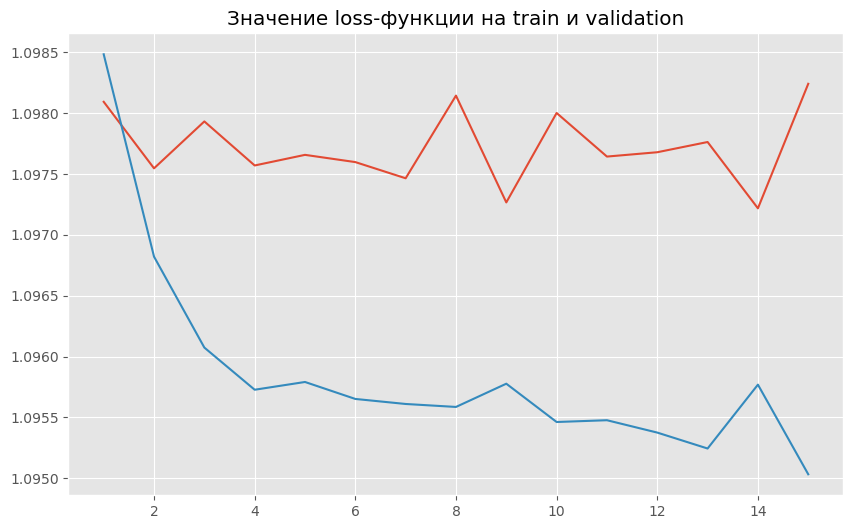

In [90]:
x = np.linspace(1, 15, 15)
fig = plt.figure(figsize = (10, 6))

plt.plot(x, val_loss)
plt.plot(x, train_loss)
plt.title('Значение loss-функции на train и validation')
plt.show()

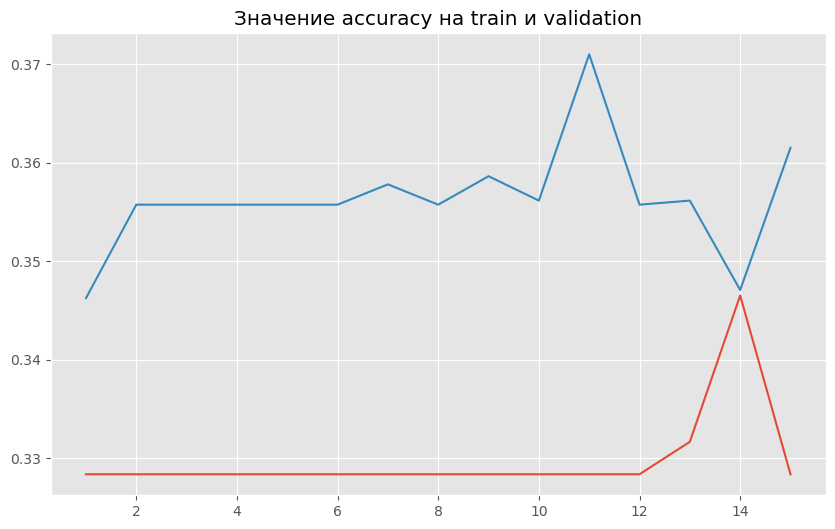

In [91]:
x = np.linspace(1, 15, 15)
fig = plt.figure(figsize = (10, 6))

plt.plot(x, val_acc)
plt.plot(x, train_acc)
plt.title('Значение accuracy на train и validation')
plt.show()